In [455]:
##### ETL NOTEBOOK FOR 2023 NCAA D1 REGIONAL DATA - 16 HOSTS + 3 Finals SITES

#### Adapted from ETL for JSON

## Dependencies and Setup
### Dependencies

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import time
import pyproj
from shapely.geometry import Polygon
from shapely.ops import transform


## Start timer
start_time = time.time()

In [456]:
## LOAD BLOCK###

### Get the Field data to merge in later
## Load the data from the csv file
conf_df = pd.read_csv('data/NCAA_D1/NCAA_regional_sites.csv') # site info (names, colors, etc.)
games_df = pd.read_csv('NCAA_GAME_DATA.csv') # data with runs scored, home runs for each game

#### Load data from kml file exported from Google Earth
file_path = ('data/kml/NCAA_regional.kml') # file path to kml file


# Read the KML file
with open(file_path) as file:
    xml_data = file.read()

# Initialize soup variables for parsing file
soup = BeautifulSoup(xml_data, 'xml')
folders = soup.Document
list = soup.Document.find_all('Folder')

# Create a list to store rows to append to the DataFrame
rows = []

# Loop through the folders and extract the data
for folder in list:
    try:
        field_name = folder.find('name').text
        foul = folder.find_all('coordinates')[0].text
        fop = folder.find_all('coordinates')[1].text
        notes = None

        # Check if there is a description tag, if so, use it for notes
        if folder.find('description') is not None:
            notes = folder.find('description').text

        row = {
            'field': field_name,
            'foul': foul,
            'fop': fop,
            'notes': notes
        }

        rows.append(row)

    except Exception as e:
        # Add name of folder to a list of failed folders
        failed.append(folder.find('name').text)
        print(f"Error processing folder: {folder.find('name').text}. Error message: {str(e)}")

# Convert the list of rows to a DataFrame
df = pd.DataFrame(rows, columns=['field', 'foul', 'fop', 'notes'])

In [457]:
# Clean the Geography dataframe


# Create a copy of the original DataFrame
df_cleaned = df.copy()

# Remove new line and space characters from coordinates
df_cleaned = df_cleaned.replace(r'\n','', regex=True) 
df_cleaned = df_cleaned.replace(r'\t','', regex=True) 

# Drop any duplicate rows
df_cleaned = df_cleaned.drop_duplicates(subset=['field'], keep='first')

# Drop any rows with empty fields
df_cleaned = df_cleaned[(df_cleaned != 0).all(1)]

##### Clean up polygon data and create a new home_plate column

def parse_coordinates(coord_string):
    coords = coord_string.split()
    parsed_coords = [tuple(map(float, coord.split(',')[:2])) for coord in coords]
    return parsed_coords

# Create a new column for the home_plate location using the first set of coordinates in the 'fop' column
df_cleaned['home_plate'] = df_cleaned['fop'].apply(lambda x: parse_coordinates(x)[0])

# Apply the parse_coordinates function to the 'foul' and 'fop' columns
df_cleaned['foul'] = df_cleaned['foul'].apply(parse_coordinates)
df_cleaned['fop'] = df_cleaned['fop'].apply(parse_coordinates)

# Rename the field column to match the other DataFrame
df_cleaned = df_cleaned.rename(columns={'field': 'park_name'})

In [458]:
df_cleaned.info()

conf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 22
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   park_name   23 non-null     object
 1   foul        23 non-null     object
 2   fop         23 non-null     object
 3   notes       4 non-null      object
 4   home_plate  23 non-null     object
dtypes: object(5)
memory usage: 1.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   park_name       22 non-null     object
 1   plotted?        22 non-null     object
 2   game_info       19 non-null     object
 3   division        22 non-null     int64 
 4   host_school     22 non-null     object
 5   nickname        22 non-null     object
 6   logo_file       22 non-null     object
 7   display_name    22 non-null     object
 8   display_name2   8 non-null    

In [459]:
### Spacial Calculations


def calculate_area(coords):
    # Create a Polygon object from the coordinates
    polygon = Polygon(coords)

    # Calculate the centroid of the polygon
    centroid = polygon.centroid

    # Create a custom LAEA projection centered on the centroid
    custom_projection = f"+proj=laea +lat_0={centroid.y} +lon_0={centroid.x} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

    # Create a transformer for converting coordinates to the custom LAEA projection
    transformer = pyproj.Transformer.from_crs(
        pyproj.CRS("EPSG:4326"),  # WGS 84 (latitude and longitude)
        pyproj.CRS(custom_projection),  # Custom LAEA projection
        always_xy=True
    )

    # Define a function to transform coordinates using the transformer
    def transform_coordinates(x, y):
        return transformer.transform(x, y)

    # Convert the coordinates to the custom LAEA projection
    polygon_laea = transform(transform_coordinates, polygon)

    # Calculate the area in square meters
    area_sqm = polygon_laea.area

    # Convert the area to square feet (1 square meter = 10.764 square feet)
    area_sqft = area_sqm * 10.764

    return area_sqft



### Call Function and add to dataframe
df_cleaned['foul_area_sqft'] = df_cleaned['foul'].apply(calculate_area)
df_cleaned['fop_area_sqft'] = df_cleaned['fop'].apply(calculate_area)

## Calculate the total area of the field and the ratio of foul area to field area
df_cleaned['field_area_sqft'] = df_cleaned['foul_area_sqft'] + df_cleaned['fop_area_sqft']
## Percentage foul area
df_cleaned['foul_area_per'] = df_cleaned['foul_area_sqft'] / df_cleaned['field_area_sqft']
## Fair to Foul Ratio
df_cleaned['fair_to_foul'] = df_cleaned['fop_area_sqft'] / df_cleaned['foul_area_sqft']

############# FENCE DISTANCE CALCULATION #############

from geopy.distance import great_circle
import numpy as np



def interpolate_points(start, end, length_ratio):
    start_np = np.array(start)
    end_np = np.array(end)
    return tuple(start_np + (end_np - start_np) * length_ratio)

def calculate_distances(home_plate, outfield_coords, num_points=540):
    def is_same_point(point1, point2, tolerance=1e-6):
        return abs(point1[0] - point2[0]) < tolerance and abs(point1[1] - point2[1]) < tolerance

    home_plate_lat_lon = (home_plate[1], home_plate[0])
    distances = []

    # Calculate total line length
    total_length = 0
    segments = []
    for i in range(len(outfield_coords) - 1):
        start = outfield_coords[i]
        end = outfield_coords[i + 1]
        if not is_same_point(home_plate, start) and not is_same_point(home_plate, end):
            segment_length = great_circle((start[1], start[0]), (end[1], end[0])).feet
            segments.append((start, end, segment_length))
            total_length += segment_length

    # Calculate the distance between equally spaced points
    spacing = total_length / (num_points - 1)

    # Interpolate points and calculate distances
    current_length = 0
    segment_index = 0
    for i in range(num_points):
        while segment_index < len(segments) - 1 and current_length > segments[segment_index][2]:
            current_length -= segments[segment_index][2]
            segment_index += 1

        start, end, segment_length = segments[segment_index]
        length_ratio = current_length / segment_length
        point = interpolate_points(start, end, length_ratio)
        distance = great_circle(home_plate_lat_lon, (point[1], point[0])).feet
        distances.append(distance)

        current_length += spacing

    return distances

# Calculate distances for each row
df_cleaned['distances'] = df_cleaned.apply(lambda row: calculate_distances(row['home_plate'], row['fop']), axis=1)

# Calculate max, min, and average distances for each row
df_cleaned['max_distance'] = df_cleaned['distances'].apply(max)
df_cleaned['min_distance'] = df_cleaned['distances'].apply(min)
df_cleaned['avg_distance'] = df_cleaned['distances'].apply(lambda distances: sum(distances) / len(distances))
# get the median distance
df_cleaned['median_distance'] = df_cleaned['distances'].apply(lambda distances: np.median(distances))

## Merge field info df into the geometry df
df = pd.merge(df_cleaned, conf_df, on='park_name', how='outer')

### rename logo column to work with existing javascript
df.rename(columns={'logo_file': 'filename'}, inplace=True)

# Drop rows that do not have a value of 1 in the division column
df = df[df['division'] == 1]




In [460]:

## Updated from MHSAAA to create Standard Div +/- Lines

## create the min max and mean fence distance rows
# Transpose the dataframe to get the 
transposed_df = pd.DataFrame(df['distances'].to_list()).transpose()

# Calculate min, max, mean, median, Q1 and Q3 for each row
min_fence_distances = transposed_df.min(axis=1)
max_fence_distances = transposed_df.max(axis=1)
mean_fence_distances = transposed_df.mean(axis=1)
median_fence_distances = transposed_df.median(axis=1)
## create profiles for standard deviation
std_fence_distances = transposed_df.std(axis=1)
first_fence_distances = mean_fence_distances + std_fence_distances
third_fence_distances = mean_fence_distances - std_fence_distances

# Create a new DataFrame to store these values
new_df = pd.DataFrame({
    'park_name': ['Min', 'Max', 'Mean', 'Median', 'Q1', 'Q3'],
    'distances': [
        min_fence_distances.tolist(), 
        max_fence_distances.tolist(),
        mean_fence_distances.tolist(),
        median_fence_distances.tolist(), # Add a comma here
        first_fence_distances.tolist(),
        third_fence_distances.tolist()
    ]
})

# For all other columns in the original DataFrame, add a column of NaN values in the new DataFrame
for column in df.columns:
    if column not in new_df.columns:
        new_df[column] = np.nan

# Concatenate the new DataFrame with the original one
df = pd.concat([df, new_df], ignore_index=True)

In [461]:
# df.head()
# df.info()

In [462]:
## Match and merge the game stats witht he field data

## do some calculations on the game data
games_df['hits'] = games_df['hits_1'] + games_df['hits_2']
games_df['home_runs'] = games_df['home_runs_1'] + games_df['home_runs_2']
games_df['total_runs'] = games_df['runs_1'] + games_df['runs_2']

## Calculate how many games were played at each site



# Group by the site add a column for the number of games at the site and sum the runs, hits, and home runs 
by_site_df = games_df.groupby('game_info')['total_runs', 'hits', 'home_runs'].sum().sort_values(by='total_runs', ascending=False)

# Add a column for the number of games at the site
by_site_df['games'] = games_df['game_info'].value_counts()

# Calculate per game stats
by_site_df['runs_per_game'] = (by_site_df['total_runs'] / by_site_df['games']).round(2)
by_site_df['hits_per_game'] = (by_site_df['hits'] / by_site_df['games']).round(2)
by_site_df['home_runs_per_game'] = (by_site_df['home_runs'] / by_site_df['games']).round(2)

# Rank the sites by HR per game
by_site_df['HR_G_rank'] = by_site_df['home_runs_per_game'].rank(ascending=False, method='min')

# Make sure some of the columns are integers so they display correctly on the plot
by_site_df['games'] = by_site_df['games'].astype(int)
by_site_df['home_runs'] = by_site_df['home_runs'].astype(int)
by_site_df['total_runs'] = by_site_df['total_runs'].astype(int)


# merge the game data with the field data
df = pd.merge(df, by_site_df, left_on='game_info', right_on=by_site_df.index, how='outer')



C:\Users\Justin\AppData\Local\Temp\ipykernel_4896\3731477833.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_site_df = games_df.groupby('game_info')['total_runs', 'hits', 'home_runs'].sum().sort_values(by='total_runs', ascending=False)


In [463]:
# ## round the runs, hits and home runs per game to 2 decimal places
# df['runs_per_game'] = df['runs_per_game'].round(2)
# df['hits_per_game'] = df['hits_per_game'].round(2)
# df['home_runs_per_game'] = df['home_runs_per_game'].round(2)




df.head()
# df.describe()

,park_name,foul,fop,notes,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,...,surface,description,total_runs,hits,home_runs,games,runs_per_game,hits_per_game,home_runs_per_game,HR_G_rank
0,TCU - Texas Christian - college,"[(-97.3724679, 32.7032071), (-97.3714306000000...","[(-97.3724679, 32.7032071), (-97.3727462000000...",None,"(-97.3724679, 32.7032071)",27085.533523,101133.142525,128218.676047,0.211245,3.733843,...,Natural Bermuda Turf,"Lupton Stadium, the home of TCU Horned Frogs b...",25.0,34.0,6.0,2.0,12.50,17.00,3.0,9.0
1,Southern Miss,"[(-89.3385631, 31.3332318), (-89.3385577, 31.3...","[(-89.3385631, 31.3332318), (-89.3374781, 31.3...",None,"(-89.3385631, 31.3332318)",28157.835307,105164.546881,133322.382189,0.211201,3.734824,...,Artificial turf,NaN,43.0,74.0,12.0,3.0,14.33,24.67,4.0,4.0
2,Oregon University - college,"[(-123.0659956, 44.0593731), (-123.0647276, 44...","[(-123.0659956, 44.0593731), (-123.0658863, 44...",None,"(-123.0659956, 44.0593731)",22666.475382,107679.700890,130346.176271,0.173894,4.750615,...,NaN,NaN,46.0,59.0,18.0,3.0,15.33,19.67,6.0,1.0
3,Charles Schwab Field Omaha - college,"[(-95.93202390000002, 41.2671943), (-95.930798...","[(-95.93202390000002, 41.2671943), (-95.932004...",None,"(-95.93202390000002, 41.2671943)",29845.574280,108845.278059,138690.852339,0.215195,3.646949,...,Kentucky Bluegrass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [464]:
## Validate the color values used in the plot

import matplotlib.colors as mcolors


def validate_color(color, default='black'):
    # Check if color is NaN (which is of float type), if yes, return default color
    if pd.isnull(color):
        return default

    # Strip non-breaking spaces and other leading/trailing whitespace
    color = color.strip()
    
    # Check if color is a valid hex color code
    if re.match('^#[0-9a-fA-F]{6}$', color):
        return color
    
    # Check if color is a valid matplotlib color name
    if color in mcolors.CSS4_COLORS:
        return color

    # If color is not valid, return the default color
    return default

In [465]:
## Set the output directory for the Outfield Fence Plots

output_dir = 'data/NCAA_D1/assests/graphs/TEMP/'

def plot_distances(df, row_index):
    # Get rows with 'Min', 'Max', 'Mean', 'Q1', 'Q3' in 'park_name'
    rows_to_plot = df[df['park_name'].isin(['Min', 'Max', 'Mean', 'Q1', 'Q3'])]
    
    # Get the row to be highlighted
    highlighted_row = df.loc[row_index]
    
    # Create a new figure
    plt.figure(figsize=(8,6))
    
    
    # Loop over these rows and plot a line graph for each
    for index, row in rows_to_plot.iterrows():
        if row['park_name'] in ['Q1', 'Q3']: # If Q1 or Q3, plot thinner, dotted line
            plt.plot(row['distances'], linestyle='dotted', alpha=0.3, color='grey', label=row['park_name'])
        else:
            plt.plot(row['distances'], linestyle='dashed', alpha=0.5, label=row['park_name'])

        # Add text labels for Min, Max and Mean lines
        if row['park_name'] in ['Min', 'Max', 'Mean']:
            plt.text(len(row['distances'])-1, row['distances'][-1], row['park_name'], color='blue', va='center')

        ## Shade the standard green below the Min Line
        # Check if the current row is 'Min', if so, add shading
        if row['park_name'] == 'Min':
            plt.fill_between(range(len(row['distances'])), plt.ylim()[0], row['distances'], color='green', alpha=0.4)

        # # SHADES IN TEAM COLOR BELOW MIN LINE
        # if row['park_name'] == 'Min' and pd.notnull(highlighted_row['color1']):
        #     plt.fill_between(range(len(row['distances'])), row['distances'], color=highlighted_row['color1'], alpha=0.4)

        # Check if the current row is 'Max', if so, add shading
        if row['park_name'] == 'Max':
            plt.fill_between(range(len(row['distances'])), row['distances'], color='yellow', alpha=0.2)

        # # Check if the current row is 'Max', if so, add shading above
        # if row['park_name'] == 'Max':
        #     plt.fill_between(range(len(row['distances'])), plt.ylim()[1], row['distances'], color='red', alpha=0.3)

        ## SHADE IN USING TEAM COLORS ABOVE MAX LINE
        if row['park_name'] == 'Max' and pd.notnull(highlighted_row['color1']):
            plt.fill_between(range(len(row['distances'])), plt.ylim()[1], row['distances'], color=highlighted_row['color1'], alpha=1.0)

            
    # Plot the highlighted row with a thicker line
    plt.plot(highlighted_row['distances'], linewidth=2, label=highlighted_row['park_name'])
    
    # Set the minimum and maximum values of y-axis
    plt.ylim([300, 420])

    # set the font for all the labels
    plt.rcParams['font.family'] = 'sans-serif'

    # Change y-axis labels and tick marks to be white
    plt.ylabel('Distance (feet)', color='white')
    plt.tick_params(axis='y', colors='white')

    # Hide x axis ticks
    plt.xticks([])

    # Add a main title and subtitle with the field name and host school
    plt.suptitle(f"{highlighted_row['display_name']}", color='black', fontsize=20, y=.25)
    plt.title(f"({highlighted_row['host_school']})", color='black', fontsize=16, y=.05)

    # Add text with statistics for each field
    plt.annotate(f"Home Runs: {highlighted_row['home_runs']}", xy=(0.05, 0.90), xycoords='axes fraction', color=validate_color(highlighted_row['color2']), fontsize=20, weight='bold', ha="left", va="bottom")
    plt.annotate(f"Rank: {highlighted_row['HR_G_rank']}", xy=(0.65, 0.90), xycoords='axes fraction', color=validate_color(highlighted_row['color2']), fontsize=20, weight='bold', ha="left", va="bottom")
    plt.annotate(f"Games: {highlighted_row['games']}", xy=(0.05, 0.85), xycoords='axes fraction', color=validate_color(highlighted_row['color2']), fontsize=16, ha="left", va="bottom")
    plt.annotate(f"HR / G: {highlighted_row['home_runs_per_game']}", xy=(0.7, 0.85), xycoords='axes fraction', color=validate_color(highlighted_row['color2']), fontsize=16, ha="left", va="bottom")


    
    #Games: {highlighted_row['games']} HR / G: {highlighted_row['home_runs_per_game']} ", xy=(0.05, 0.95), xycoords='axes fraction', color="white", fontsize=16, ha="left", va="bottom")


    

    
    

    # Reverse the x-axis
    # plt.gca().invert_xaxis()

    # Generate the file path
    file_path = os.path.join(output_dir, f"plot_{highlighted_row['HR_G_rank']}_{highlighted_row['host_school']}.png")
    
    # Save the figure
    plt.savefig(file_path)

    # Close the figure to free up memory
    plt.close()

    # Return the file path
    return file_path

# Add a new column 'file_path' to the DataFrame to store the file paths
df['file_path'] = [plot_distances(df, i) for i in df.index]




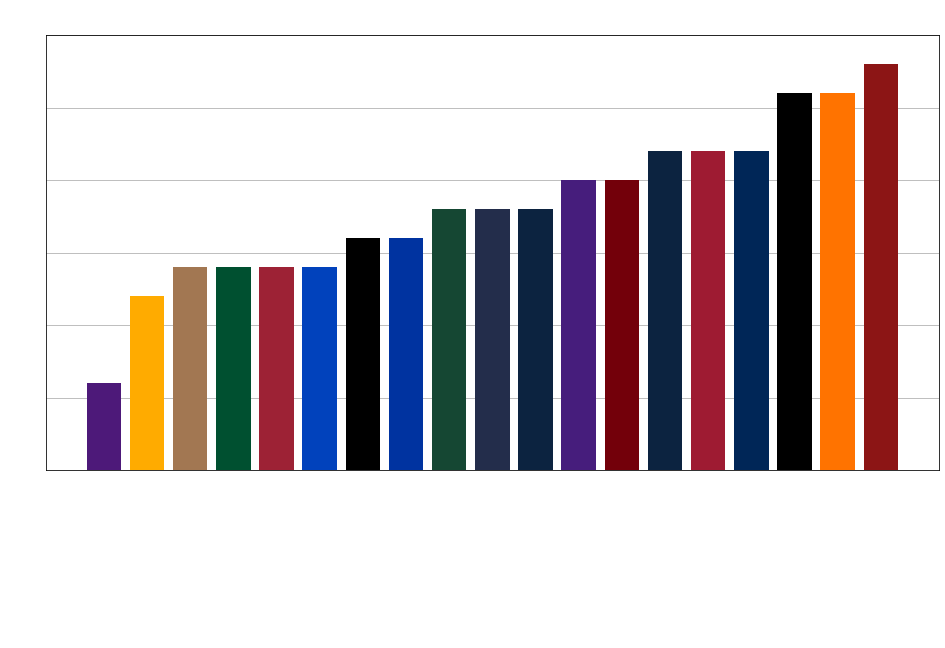

In [495]:
# Make a plot of the total home runs hit at each ballpark
# order from greatest to smallest

# Drop rows with NaN values in 'host_school' column
df = df.dropna(subset=['host_school'])
# Drop rows with NaN values in 'home_runs' column
df = df.dropna(subset=['home_runs'])

# Convert 'host_school' column to string
df['host_school'] = df['host_school'].astype(str)

# Sort values for better visualization
df = df.sort_values(by='home_runs')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(16,8))
# Put a grid on the plot
ax.grid(True, which='major', axis='y')
ax.set_axisbelow(True) # make sure grid is behind bars


# Create a bar plot
bars = ax.bar(df['host_school'], df['home_runs'], color=df['color1'])

# Set the y limit
ax.set_ylim([0, 30])

# Set labels
# ax.set_xlabel('Host School')
ax.set_ylabel('Home Runs')

# Set title
ax.set_title('Total Home Runs By Game Site')
# adjust the font size
ax.title.set_fontsize(28)

# Optional: rotate x-axis labels if they overlap
plt.xticks(rotation=90)

#change the text color to white for the x and y axis and labels
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', labelsize=20)
ax.tick_params(axis='y', colors='white', labelsize=10)

# Change font size for x and y axis labels
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
# Add a grid





# Save the plot before showing it
plt.savefig('data/NCAA_D1/assests/graphs/TEMP/home_runs_by_park.png')

# Then you can show the plot
plt.show()



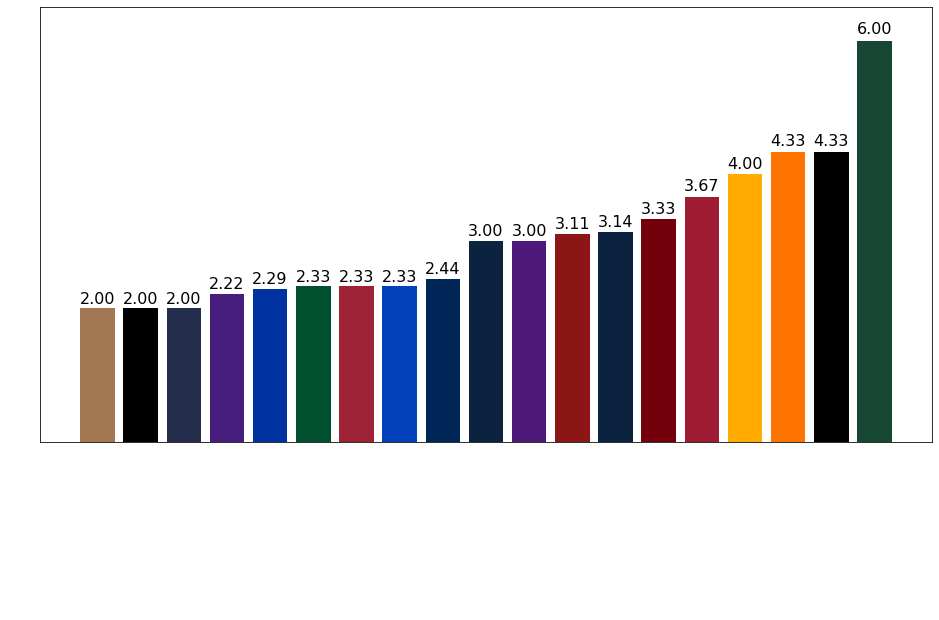

In [489]:
# Make a plot of the total home runs hit at each ballpark
# order from greatest to smallest

# Drop rows with NaN values in 'host_school' column
df = df.dropna(subset=['host_school'])

# Convert 'host_school' column to string
df['host_school'] = df['host_school'].astype(str)


# Sort values for better visualization
df = df.sort_values(by='home_runs_per_game')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(16,8))

# Create a bar plot
bars = ax.bar(df['host_school'], df['home_runs_per_game'], color=df['color1'])

# add the value at the top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., 1.01*height, '%.2f' % height, ha='center', va='bottom',
    fontsize=16)


# Set the y limit
ax.set_ylim([0, 6.5])


# Set labels
# ax.set_xlabel('Host School')
ax.set_ylabel('Home Runs per Game')
#Set font size for y axis label

# Set title
# ax.set_title('Home Runs per Game')

# Optional: rotate x-axis labels if they overlap
plt.xticks(rotation=90)

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', labelsize=20)
ax.tick_params(axis='y', colors='white', labelsize=10)

# Change font size for x and y axis labels
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)



# Save the plot before showing it
plt.savefig('data/NCAA_D1/assests/graphs/TEMP/home_runs_per_game.png')

# Then you can show the plot
plt.show()
